# Catastrophic forgetting for multi-classification

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd 
import models as models
# Set the seed for PyTorch
torch.manual_seed(42)

Adapted from Original Pytorch github https://github.com/pytorch/examples/blob/main/mnist/main.py 

In [2]:
def auto_remap_target(target, class_list):
    """
    Automatically remap target values to the range [0, num_classes-1].

    Args:
    - target (torch.Tensor): Target tensor with original class indices.
    - class_list (list): List of class indices in your classification task.

    Returns:
    - torch.Tensor: Remapped target tensor.
    """
    remap_dict = {class_val: idx for idx, class_val in enumerate(class_list)}
    remapped_target = torch.tensor([remap_dict[val.item()] for val in target])
    return remapped_target

def inverse_remap_target(remapped_target, class_list):
    """
    Map remapped target values back to their original values.

    Args:
    - remapped_target (torch.Tensor): Remapped target tensor.
    - class_list (list): List of class indices in your classification task.

    Returns:
    - torch.Tensor: Original target tensor.
    """
    original_target = torch.tensor([class_list[idx] for idx in remapped_target])
    return original_target



def train(args, model, device, train_loader, optimizer, epoch, label_types=[0, 1, 2, 3, 4, 5]):
    """
    Train the neural network model using negative log-likelihood loss for multi classification.

    Args:
    - args: Commacnd-line arguments and configurations.
    - model: The neural network model to be trained.
    - device: The device to which data and model should be moved (e.g., "cuda" for GPU or "cpu").
    - train_loader: DataLoader providing training data.
    - optimizer: Optimizer for updating model parameters.
    - epoch: The current epoch number.
    - label_types: unique labels per task

    Returns:
    - accuracy: Accuracy of the model on the training set.
    - average_loss: Average binary cross-entropy loss over the training set.
    """
    model.train()
    total_loss = 0.0
    correct = 0
    

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        remapped_target = auto_remap_target(target, label_types)
        
        loss = F.nll_loss(output, remapped_target)
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        pred = inverse_remap_target(pred, label_types)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss.backward()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

    # Calculate and return the average loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100.*correct / len(train_loader.dataset)
    return accuracy, average_loss

def validate(model, device, dataloader, label_types=[0, 1, 2, 3, 4, 5]):
    """
    Evaluate the neural network model on a validation or test set using binary cross-entropy loss for binary classification.

    Args:
    - model: The neural network model to be evaluated.
    - device: The device to which data and model should be moved (e.g., "cuda" for GPU or "cpu").
    - test_loader: DataLoader providing validation or test data.

    Returns:
    - accuracy: Accuracy of the model on the validation or test set.
    - val_loss: Binary cross-entropy loss on the validation or test set.
    - all_predictions: Predicted labels for all instances in the validation or test set.
    - all_labels: True labels for all instances in the validation or test set.
    """
    model.eval()
    val_loss = 0
    correct = 0
    
    all_predictions = []
    all_labels = []

    
    with torch.no_grad():
            for data, target in dataloader:
                
                data, target = data.to(device), target.to(device)
                output = model(data)
                remapped_target = auto_remap_target(target, label_types)
                val_loss = F.nll_loss(output, remapped_target, reduction='sum').item()
                pred = output.argmax(dim=1)  # get the index of the max log-probability
                pred = inverse_remap_target(pred, label_types)
                correct += pred.eq(target.view_as(pred)).sum().item()
                all_predictions.append(pred.cpu().numpy())
                all_labels.append(target.cpu().numpy())
    
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions).squeeze(0)
    all_labels = np.array(all_labels).squeeze(0)
    
    val_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    print('\Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(dataloader.dataset),
        100. * correct / len(dataloader.dataset)))
    
    return accuracy, val_loss, all_predictions, all_labels
    
def train_and_validate(args, 
                       model, 
                       device, 
                       train_loader, 
                       val_loader, 
                       optimizer, 
                       scheduler, 
                       title = "", 
                       type_label=[0, 1, 2, 3, 4, 9],
                       model_path= "model.pt"):
    """
    Train and validate a neural network model across multiple epochs.

    Args:
    - args: Command-line arguments and configurations.
    - model: The neural network model to be trained and validated.
    - device: The device to which data and model should be moved (e.g., "cuda" for GPU or "cpu").
    - train_loader: DataLoader providing training data.
    - val_loader: DataLoader providing validation or test data.
    - optimizer: Optimizer for updating model parameters.
    - scheduler: Learning rate scheduler.
    - title: Title for the plot (optional).
    - model_path: path to store the model

    Returns:
    - all_predictions: Predicted labels for all instances in the validation or test set.
    - all_labels: True labels for all instances in the validation or test set.
    """
    train_losses = [] 
    train_accuracies = [] 
    val_accuracies = [] 
    val_losses = [] 
    best_val_loss = float('inf')
    best_epoch = 0

    for epoch in range(1, args.epochs + 1):
        train_accuracy, train_loss = train(args, model, device, train_loader, optimizer, epoch,type_label)
        val_accuracy, val_loss, all_predictions, all_labels = validate(model, device, val_loader,type_label)
        scheduler.step()
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)
        if val_loss<best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            if os.path.exists(model_path):
                os.remove(model_path)
            torch.save(model.state_dict(), model_path)


        print(f'Epoch {epoch}/{args.epochs}: Training Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch + 1}")
    # Plot loss and accuracy after all epochs
    plot_loss_and_accuracy(train_accuracies, train_losses, val_accuracies, val_losses, title)
    
    return all_predictions, all_labels

def save_model_state_dict(model_state_dict, filename, overwrite=True):
    """
    Save the state dictionary of a PyTorch model to a file.

    Args:
    - model_state_dict: The state dictionary of the PyTorch model.
    - filename: The name of the file to which the state dictionary will be saved.
    - overwrite: Boolean flag indicating whether to overwrite an existing file (default is True).

    Returns:
    - None
    """
    models_folder = "models"
    
    # Check if the models folder exists, if not, create it
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)

    file_path = os.path.join(models_folder, filename)

    # Check if the file already exists
    if os.path.exists(file_path) and not overwrite:
        user_input = input(f"The file '{filename}' already exists. Do you want to overwrite it? (yes/no): ")
        if user_input.lower() != 'yes':
            print("Model not saved.")
            return

    # Save the model state dict
    torch.save(model_state_dict, file_path)
    print(f"Model state dict saved to: {file_path}")

def plot_loss_and_accuracy(train_accuracies, train_losses, val_accuracies, val_losses, title = ""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Training Loss and Accuracy
    
    ax1.plot(train_accuracies, label='Training Accuracy')
    ax1.plot(val_accuracies, label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_title(f'{title} - training data')
    ax1.legend()

    # Plot Testing Loss and Accuracy
    ax2.plot(train_losses, label='Training Loss')
    ax2.plot(val_losses, label='Validation Loss')
    
    ax2.set_xlabel('Epoch')
    ax2.set_title(f'{title} - validation data')
    ax2.legend()
    
def get_data_loaders(dataset, train_size, val_size, train_kwargs, val_kwargs):
    train_set, val_set = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, **train_kwargs)
    val_loader = DataLoader(val_set, **val_kwargs)
    print(len(train_loader), len(val_loader))
    return train_loader, val_loader

In [3]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=2, metavar='N',
                        help='input batch size for training (default: 64)')
parser.add_argument('--val-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=15, metavar='N',
                        help='number of epochs to train (default: 14)')
parser.add_argument('--lr_t1', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
parser.add_argument('--lr_t2', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')                        
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
parser.add_argument('--val_reduced', action='store_true', default=True,
                        help='For Saving the current Model')
parser.add_argument('--dataset', action='store_true', default=1,
                        help='0 for MNIST, 1 for MNIST')
parser.add_argument('--device', action='store_true', default=torch.device("cpu"),
                        help='.')

args, unknown = parser.parse_known_args()
DATASET = args.dataset
use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

device = args.device
train_kwargs = {'batch_size': args.batch_size}
val_kwargs = {'batch_size': args.val_batch_size}
if 'cuda' in str(device):
        cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        val_kwargs.update(cuda_kwargs)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
if DATASET==0:
        mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
elif DATASET==1:
        mnist_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
        
if args.val_reduced:
        sampled_indices = torch.randperm(len(mnist_dataset))[:2000]
        mnist_dataset = Subset(mnist_dataset, sampled_indices)


Unique Labels in Dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Selected labels for Task 1: {0, 1, 2, 3, 4}
410 1


Train Epoch: 1 [0/820 (0%)]	Loss: 1.548448
Train Epoch: 1 [20/820 (2%)]	Loss: 1.460284
Train Epoch: 1 [40/820 (5%)]	Loss: 1.635930
Train Epoch: 1 [60/820 (7%)]	Loss: 1.395108
Train Epoch: 1 [80/820 (10%)]	Loss: 2.835683
Train Epoch: 1 [100/820 (12%)]	Loss: 0.739133
Train Epoch: 1 [120/820 (15%)]	Loss: 2.476790
Train Epoch: 1 [140/820 (17%)]	Loss: 0.924538
Train Epoch: 1 [160/820 (20%)]	Loss: 0.502055
Train Epoch: 1 [180/820 (22%)]	Loss: 0.070059
Train Epoch: 1 [200/820 (24%)]	Loss: 1.613911
Train Epoch: 1 [220/820 (27%)]	Loss: 0.856039
Train Epoch: 1 [240/820 (29%)]	Loss: 2.181795
Train Epoch: 1 [260/820 (32%)]	Loss: 0.083940
Train Epoch: 1 [280/820 (34%)]	Loss: 0.073665
Train Epoch: 1 [300/820 (37%)]	Loss: 0.084831
Train Epoch: 1 [320/820 (39%)]	Loss: 1.954187
Train Epoch: 1 [340/820 (41%)]	Loss: 0.302740
Train Epoch: 1 [360/820 (44%)]	Loss: 1.441462
Train Epoch: 1 [380/820 (46%)]	Loss: 0.056877
Train Epoch: 1 [400/820 (49%)]	Loss: 0.324249
Train Epoch: 1 [420/820 (51%)]	Loss: 0.08051

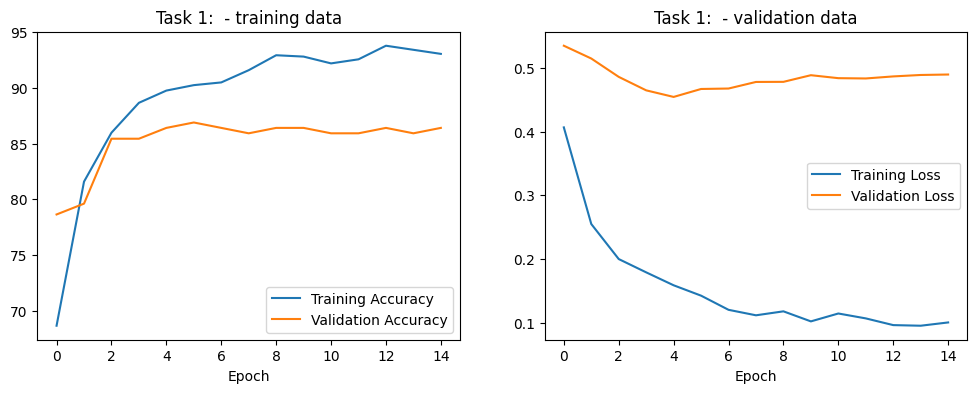

In [5]:
# Define task 1 labeling
task1_classes = [0, 1, 2, 3, 4]
# Check the unique labels in your dataset to make sure they are integers
unique_labels = set(label for _, label in mnist_dataset)
print("Unique Labels in Dataset:", unique_labels)
# Make sure labels are integers; if not, convert them to integers
mnist_dataset = [(image, int(label)) for image, label in mnist_dataset]
task1_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in task1_classes]
task1_dataset = Subset(mnist_dataset, task1_indices)
print("Selected labels for Task 1:", set(label for _, label in task1_dataset))
train_size_task1 = int(0.8 * len(task1_indices))
val_size_task1 = len(task1_indices) - train_size_task1
train_loader_task1, val_loader_task1 = get_data_loaders(task1_dataset, 
                                                        train_size_task1, 
                                                        val_size_task1,
                                                        train_kwargs, 
                                                        val_kwargs)
#model = models.Net_tunable(classes = len(task1_classes), freeze_backbone=True).to(device)
model = models.Net_log_softmax(classes = len(task1_classes)).to(device)
#model = models.AlexNet(classes = len(task1_classes)).to(device)
#model = models.BaseModel(28 * 28, 100, len(task1_classes)).to(device)

optimizer = optim.Adadelta(model.parameters(), lr=args.lr_t1)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

all_predictions, all_labels = train_and_validate(args, model, device, 
                                                 train_loader_task1, 
                                                 val_loader_task1, 
                                                 optimizer, 
                                                 scheduler,
                                                 title="Task 1: ", 
                                                 type_label=task1_classes,
                                                 model_path= "models/mnist_cnn_task1_MULTICLASS.pt"
                                                 )

print(f"import torch; print(f'CUDA version: {torch.version.cuda}\nTorch version: {torch.__version__}\ndevice count: {torch.cuda.device_count()}')\nDevice:{device}\nDataset:{DATASET}")


### Testing 
Let's evaluate the best model over the whole validation data

In [ ]:
val_accuracy, val_loss, all_predictions, all_labels  = validate(model, device, val_loader_task1,task1_classes)

\Val set: Average loss: 0.2928, Accuracy: 183/206 (89%)



In [ ]:
all_predictions

array([0, 3, 2, 1, 4, 2, 0, 2, 3, 2, 3, 3, 1, 1, 4, 2, 3, 4, 0, 1, 2, 0,
       3, 2, 1, 3, 2, 1, 2, 1, 4, 3, 4, 3, 2, 2, 2, 4, 4, 4, 2, 0, 1, 3,
       0, 2, 3, 2, 3, 0, 4, 4, 4, 4, 0, 0, 2, 4, 1, 0, 2, 1, 0, 2, 4, 3,
       4, 2, 0, 2, 0, 4, 4, 3, 1, 2, 4, 4, 2, 2, 2, 1, 4, 3, 0, 2, 1, 2,
       4, 4, 1, 3, 0, 0, 2, 2, 4, 0, 2, 2, 1, 4, 2, 3, 2, 3, 2, 2, 3, 3,
       2, 3, 1, 2, 3, 3, 4, 0, 0, 4, 3, 4, 3, 1, 1, 1, 4, 0, 0, 2, 2, 4,
       3, 0, 0, 0, 2, 1, 2, 1, 1, 4, 0, 2, 3, 1, 0, 4, 0, 3, 3, 4, 2, 3,
       4, 0, 1, 2, 0, 2, 1, 2, 0, 3, 1, 0, 1, 4, 4, 0, 3, 3, 0, 1, 1, 3,
       1, 3, 2, 3, 0, 1, 3, 1, 3, 3, 3, 3, 2, 2, 3, 3, 1, 1, 1, 3, 3, 1,
       3, 1, 3, 4, 4, 3, 4, 1], dtype=int64)

In [ ]:
all_labels

array([0, 4, 2, 1, 4, 2, 0, 2, 3, 2, 3, 3, 1, 1, 4, 2, 3, 4, 0, 1, 2, 0,
       3, 2, 1, 3, 2, 1, 4, 1, 2, 3, 4, 3, 2, 4, 2, 4, 4, 4, 2, 2, 1, 3,
       0, 2, 3, 2, 4, 0, 2, 4, 4, 2, 0, 0, 4, 4, 1, 0, 2, 1, 2, 2, 4, 3,
       4, 2, 0, 2, 0, 4, 3, 3, 1, 2, 4, 4, 2, 2, 2, 1, 4, 3, 0, 2, 1, 2,
       4, 4, 1, 0, 3, 0, 2, 2, 4, 0, 2, 2, 1, 4, 4, 3, 2, 3, 2, 2, 3, 1,
       2, 3, 1, 2, 3, 3, 4, 3, 0, 4, 3, 4, 3, 1, 1, 1, 2, 0, 0, 2, 2, 4,
       3, 0, 0, 0, 2, 1, 2, 1, 1, 2, 0, 2, 3, 1, 0, 4, 0, 1, 3, 4, 2, 3,
       4, 0, 1, 2, 0, 0, 1, 0, 0, 3, 1, 0, 1, 4, 4, 0, 3, 3, 0, 1, 1, 3,
       1, 0, 2, 3, 0, 1, 3, 1, 3, 3, 3, 3, 2, 2, 3, 3, 1, 1, 1, 3, 3, 1,
       3, 1, 0, 4, 4, 3, 4, 1], dtype=int64)

In [ ]:
np.unique(all_predictions), np.unique(all_labels)

(array([0, 1, 2, 3, 4], dtype=int64), array([0, 1, 2, 3, 4], dtype=int64))

In [ ]:
all_predictions.shape, all_labels.shape

((206,), (206,))

In [ ]:
unique_classes = np.unique(np.concatenate((all_labels, all_predictions)))
unique_classes

array([0, 1, 2, 3, 4], dtype=int64)

In [ ]:
confusion_mat = confusion_matrix(all_labels, all_predictions, labels=unique_classes)
conf_matrix = pd.DataFrame(confusion_mat, index=unique_classes, columns=unique_classes)
conf_matrix

,0,1,2,3,4
0,30,0,2,3,0
1,0,38,0,2,0
2,2,0,42,0,5
3,2,0,0,41,1
4,0,0,4,2,32


In [ ]:
confusion_mat.shape

(5, 5)

Customize your confusion matrix https://seaborn.pydata.org/generated/seaborn.heatmap.html 

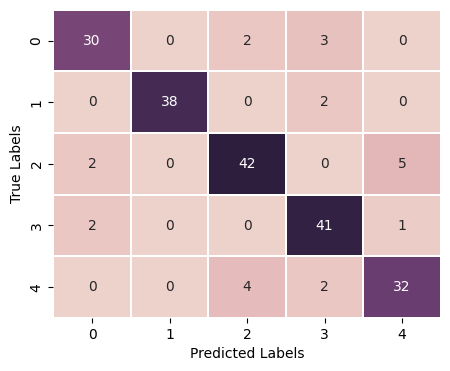

In [ ]:
import seaborn as sns

unique_classes = np.unique(np.concatenate((all_labels, all_predictions)))
confusion_mat = confusion_matrix(all_labels, all_predictions, labels=unique_classes)
conf_matrix = pd.DataFrame(confusion_mat, index=unique_classes, columns=unique_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
ax = sns.heatmap(conf_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.1, cbar=False)

# Set labels and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Set x and y ticks using the unique classes
ax.set_xticks(range(len(unique_classes)))
ax.set_yticks(range(len(unique_classes)))

# Set x and y ticks at the center of the cells
ax.set_xticks([i + 0.5 for i in range(len(unique_classes))])
ax.set_yticks([i + 0.5 for i in range(len(unique_classes))])


plt.show()


In [ ]:
np.unique(all_predictions)

array([0, 1, 2, 3, 4], dtype=int64)

In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=[str(c) for c in task1_classes]))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        35
           1       1.00      0.95      0.97        40
           2       0.88      0.86      0.87        49
           3       0.85      0.93      0.89        44
           4       0.84      0.84      0.84        38

    accuracy                           0.89       206
   macro avg       0.89      0.89      0.89       206
weighted avg       0.89      0.89      0.89       206



In [ ]:
len(val_loader_task1)

1

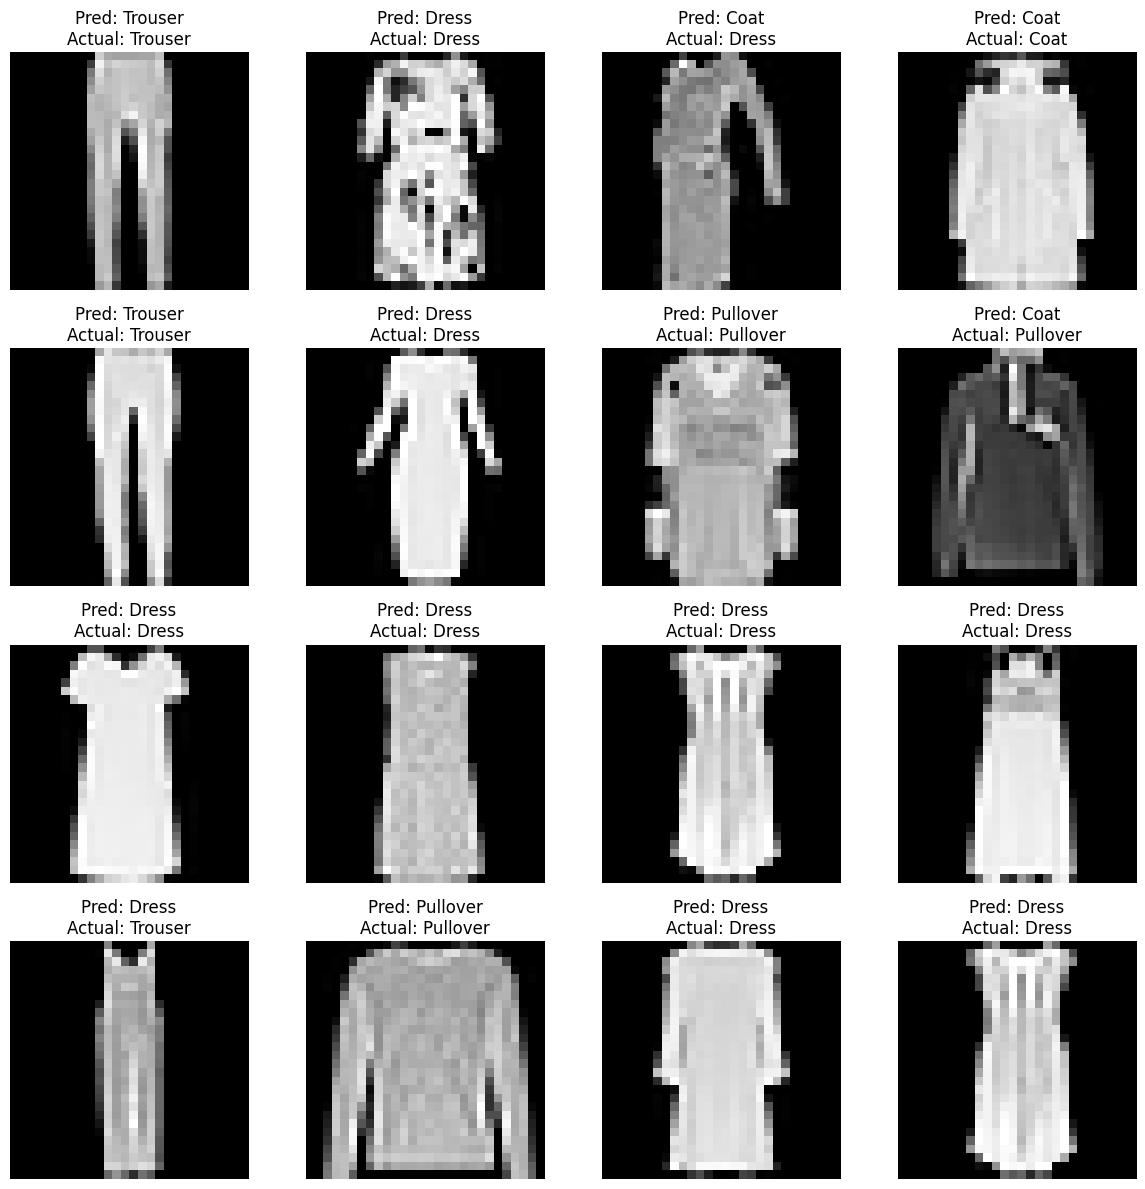

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, val_loader, device, type_label=None, dataset_type=1):
    if type_label is None:
        type_label = task1_classes

    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            pred = output.argmax(dim=1)
            pred = inverse_remap_target(pred, type_label)        
            all_predictions.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Convert predictions and labels to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Create a 4x4 grid for visualization
    num_rows = 4
    num_cols = 4

    plt.figure(figsize=(12, 12))

    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        idx = np.random.randint(len(all_labels))
        plt.imshow(data[idx].cpu().numpy().squeeze(), cmap='gray')

        # Use the class names instead of numeric labels for Fashion MNIST
        if dataset_type == 1:
            class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
            predicted_class = class_names[all_predictions[idx]]
            actual_class = class_names[all_labels[idx]]
        else:
            predicted_class = all_predictions[idx]
            actual_class = all_labels[idx]

        plt.title(f'Pred: {predicted_class}\nActual: {actual_class}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for Fashion MNIST dataset (DATASET=1)
visualize_predictions(model, val_loader_task1, device, dataset_type=DATASET)


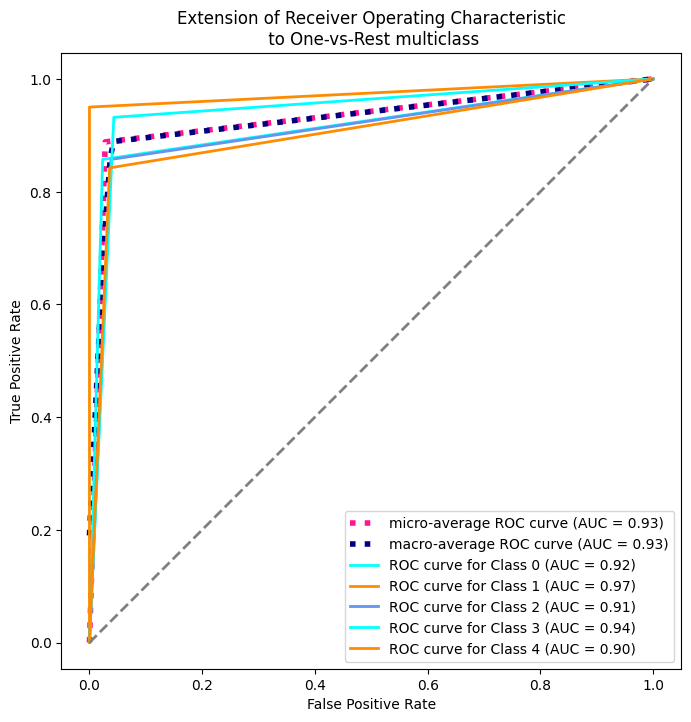

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

def plot_multiclass_roc_curve(all_labels, all_predictions):
    # Step 1: Label Binarization
    label_binarizer = LabelBinarizer()
    y_onehot = label_binarizer.fit_transform(all_labels)
    all_predictions_hot = label_binarizer.transform(all_predictions)

    # Step 2: Calculate ROC curves
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    unique_classes = range(y_onehot.shape[1])
    for i in unique_classes:
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], all_predictions_hot[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Step 3: Plot ROC curves
    fig, ax = plt.subplots(figsize=(8, 8))

    # Micro-average ROC curve
    fpr_micro, tpr_micro, _ = roc_curve(y_onehot.ravel(), all_predictions_hot.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(
        fpr_micro,
        tpr_micro,
        label=f"micro-average ROC curve (AUC = {roc_auc_micro:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    # Macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in unique_classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in unique_classes:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(unique_classes)
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(
        fpr_macro,
        tpr_macro,
        label=f"macro-average ROC curve (AUC = {roc_auc_macro:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    # Individual class ROC curves
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(unique_classes, colors):
        plt.plot(
            fpr[class_id],
            tpr[class_id],
            color=color,
            label=f"ROC curve for Class {class_id} (AUC = {roc_auc[class_id]:.2f})",
            linewidth=2,
        )

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2)  # Add diagonal line for reference
    plt.axis("equal")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\n to One-vs-Rest multiclass")
    plt.legend()
    plt.show()

# Example usage:
    
plot_multiclass_roc_curve(all_labels, all_predictions)


## Training on second task

Selected labels for Task 2: {5, 6, 7, 8, 9}
-------------------MODEL TRAINING TASK #2-------------------
390 1
Train Epoch: 1 [0/779 (0%)]	Loss: 17.940907
Train Epoch: 1 [20/779 (3%)]	Loss: 1.357549
Train Epoch: 1 [40/779 (5%)]	Loss: 1.857089
Train Epoch: 1 [60/779 (8%)]	Loss: 1.675015
Train Epoch: 1 [80/779 (10%)]	Loss: 0.122495
Train Epoch: 1 [100/779 (13%)]	Loss: 0.041345
Train Epoch: 1 [120/779 (15%)]	Loss: 0.474136
Train Epoch: 1 [140/779 (18%)]	Loss: 0.669443
Train Epoch: 1 [160/779 (21%)]	Loss: 0.247036
Train Epoch: 1 [180/779 (23%)]	Loss: 0.128716
Train Epoch: 1 [200/779 (26%)]	Loss: 0.042369
Train Epoch: 1 [220/779 (28%)]	Loss: 0.092109
Train Epoch: 1 [240/779 (31%)]	Loss: 0.004879
Train Epoch: 1 [260/779 (33%)]	Loss: 0.102751
Train Epoch: 1 [280/779 (36%)]	Loss: 1.205873
Train Epoch: 1 [300/779 (38%)]	Loss: 3.656500
Train Epoch: 1 [320/779 (41%)]	Loss: 0.215692
Train Epoch: 1 [340/779 (44%)]	Loss: 0.243920
Train Epoch: 1 [360/779 (46%)]	Loss: 0.860497
Train Epoch: 1 [380/779 

(array([7, 6, 9, 6, 7, 8, 6, 5, 9, 5, 8, 6, 9, 9, 5, 8, 5, 5, 7, 7, 7, 6,
        8, 5, 8, 5, 5, 8, 7, 8, 8, 7, 8, 7, 9, 5, 9, 5, 6, 7, 6, 8, 8, 9,
        7, 7, 9, 6, 6, 5, 8, 7, 8, 5, 8, 7, 8, 7, 6, 7, 7, 5, 6, 9, 6, 5,
        7, 5, 9, 6, 6, 6, 9, 8, 6, 6, 6, 7, 8, 6, 5, 5, 6, 8, 5, 6, 8, 5,
        5, 5, 6, 6, 9, 5, 7, 6, 9, 9, 6, 6, 9, 6, 8, 9, 8, 5, 5, 8, 9, 7,
        9, 7, 5, 9, 5, 7, 7, 6, 8, 8, 8, 6, 6, 6, 6, 5, 5, 7, 6, 5, 6, 7,
        5, 6, 8, 6, 6, 5, 6, 9, 8, 8, 8, 6, 9, 6, 5, 5, 7, 7, 7, 9, 7, 8,
        7, 5, 9, 6, 7, 8, 7, 9, 8, 7, 6, 9, 6, 6, 7, 6, 5, 7, 9, 7, 9, 9,
        6, 8, 9, 7, 7, 9, 8, 7, 5, 8, 9, 9, 6, 6, 9, 9, 7, 6, 6],
       dtype=int64),
 array([7, 6, 9, 6, 7, 8, 6, 5, 9, 5, 8, 6, 9, 9, 5, 8, 8, 5, 7, 7, 7, 6,
        8, 5, 8, 5, 5, 8, 7, 8, 8, 7, 8, 7, 9, 5, 9, 5, 6, 7, 6, 8, 8, 7,
        7, 7, 9, 6, 6, 5, 8, 7, 8, 5, 8, 7, 8, 7, 6, 7, 7, 5, 6, 9, 6, 7,
        7, 5, 9, 6, 6, 6, 9, 8, 6, 6, 6, 7, 8, 6, 5, 5, 6, 8, 5, 6, 8, 5,
        5, 5, 6, 6, 9, 5,

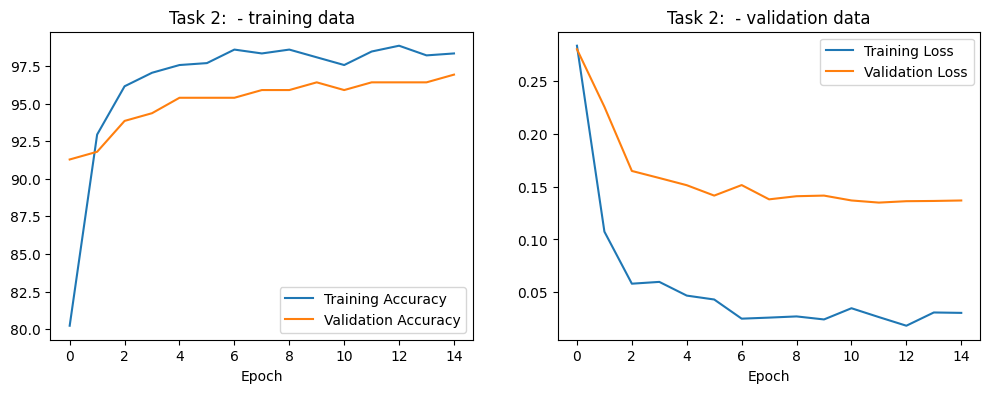

In [ ]:
task2_classes = [5, 6, 7, 8, 9]
task2_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in task2_classes]
task2_dataset = Subset(mnist_dataset, task2_indices)
print("Selected labels for Task 2:", set(label for _, label in task2_dataset))
train_size_task2 = int(0.8 * len(task2_indices))
val_size_task2 = len(task2_indices) - train_size_task2

model_task2 = models.Net_log_softmax(classes = len(task2_classes)).to(device)

#model_task2 = models.Net_tunable(classes = len(task2_classes), freeze_backbone=True).to(device)

#model_task2 = models.BaseModel(28 * 28, 100, len(task2_classes)).to(device)
#model_task2 = models.AlexNet(classes = len(task2_classes)).to(device)
model_state_dict_task1 = torch.load("models/mnist_cnn_task1_MULTICLASS.pt")
model_task2.load_state_dict(model_state_dict_task1) 
optimizer_task2 = optim.Adadelta(model_task2.parameters(), lr=args.lr_t2)
# optimizer_task2 = optim.Adadelta(model.parameters(), lr=1)
# scheduler_task2 = StepLR(optimizer_task2, step_size=1, gamma=0.7)
scheduler_task2 = StepLR(optimizer_task2, step_size=1, gamma=args.gamma)

print(f"MODEL TRAINING TASK #2".center(60, "-"))

train_loader_task2, val_loader_task2 = get_data_loaders(task2_dataset, train_size_task2, val_size_task2,train_kwargs, val_kwargs)

train_and_validate(args, 
                   model_task2, 
                   device, 
                   train_loader_task2, 
                   val_loader_task2, 
                   optimizer_task2, 
                   scheduler_task2, 
                   title="Task 2: ", 
                   type_label= task2_classes,
                   model_path="models/mnist_cnn_task2_MULTICLASS.pt")


### Test it over task-2 validation data 

In [ ]:
val_accuracy, val_loss, all_predictions, all_labels = validate(model_task2, device, val_loader_task2,task2_classes)


\Val set: Average loss: 0.1369, Accuracy: 189/195 (97%)



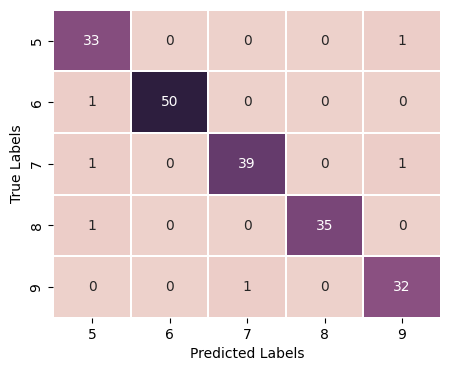

(array([5, 6, 7, 8, 9], dtype=int64), array([5, 6, 7, 8, 9], dtype=int64))

In [ ]:
unique_classes = np.unique(np.concatenate((all_labels, all_predictions)))
confusion_mat = confusion_matrix(all_labels, all_predictions, labels=unique_classes)
conf_matrix = pd.DataFrame(confusion_mat, index=unique_classes, columns=unique_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
ax = sns.heatmap(conf_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.1, cbar=False)

# Set labels and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Set x and y ticks using the unique classes
ax.set_xticks(range(len(unique_classes)))
ax.set_yticks(range(len(unique_classes)))

# Set x and y ticks at the center of the cells
ax.set_xticks([i + 0.5 for i in range(len(unique_classes))])
ax.set_yticks([i + 0.5 for i in range(len(unique_classes))])


plt.show()
np.unique(all_predictions), np.unique(all_labels)

In [ ]:
unique_classes

array([5, 6, 7, 8, 9], dtype=int64)

In [ ]:
np.unique(all_predictions), np.unique(all_labels)

(array([5, 6, 7, 8, 9], dtype=int64), array([5, 6, 7, 8, 9], dtype=int64))

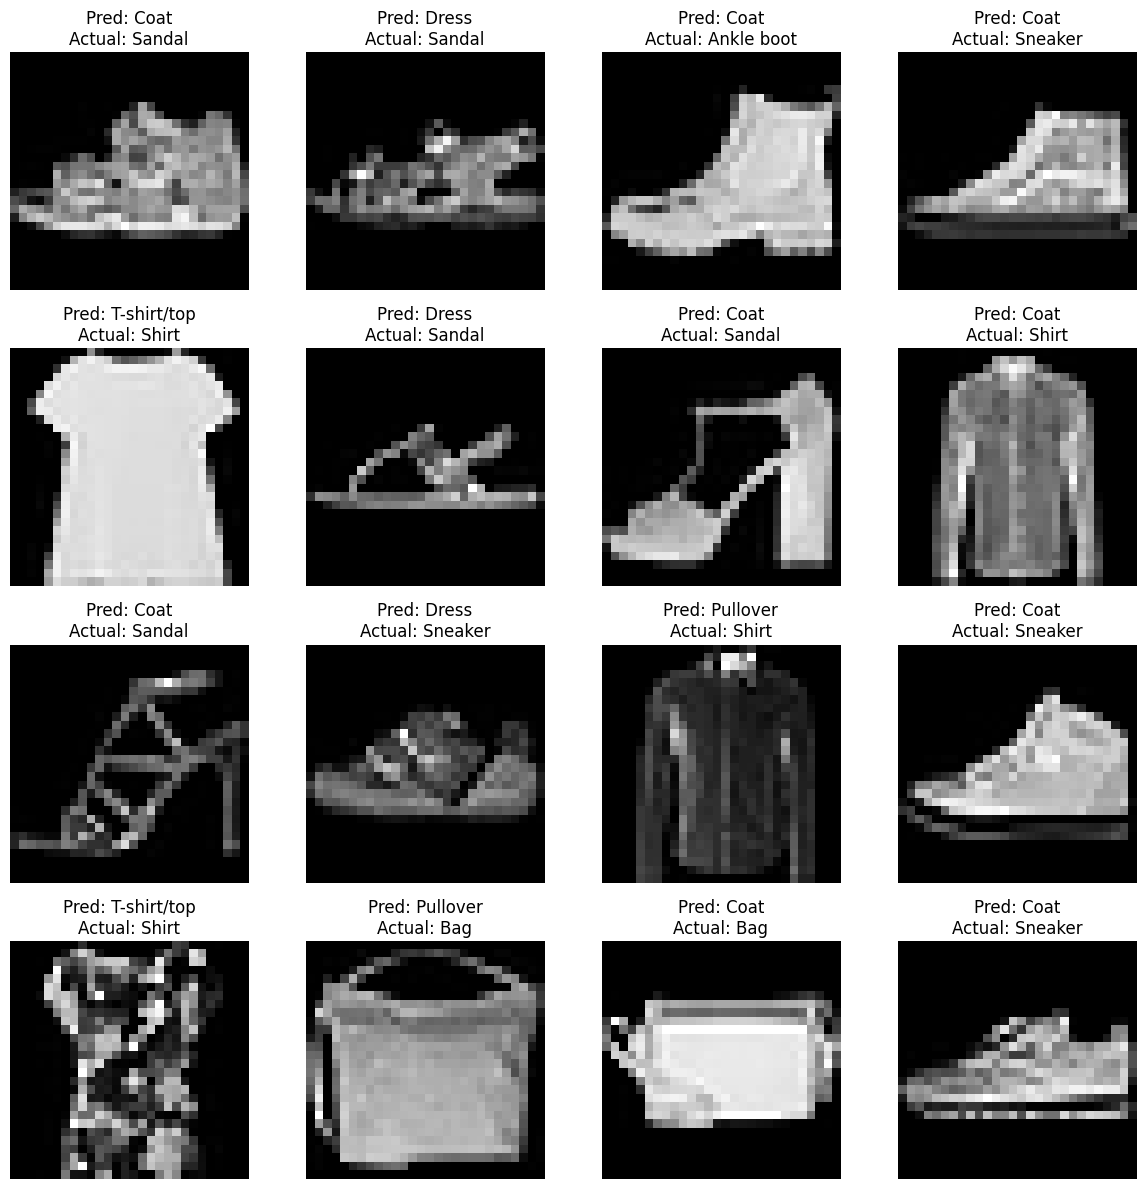

In [ ]:
visualize_predictions(model, val_loader_task2, device, dataset_type=DATASET)


In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=[str(c) for c in task2_classes]))


Classification Report:
              precision    recall  f1-score   support

           5       0.92      0.97      0.94        34
           6       1.00      0.98      0.99        51
           7       0.97      0.95      0.96        41
           8       1.00      0.97      0.99        36
           9       0.94      0.97      0.96        33

    accuracy                           0.97       195
   macro avg       0.97      0.97      0.97       195
weighted avg       0.97      0.97      0.97       195



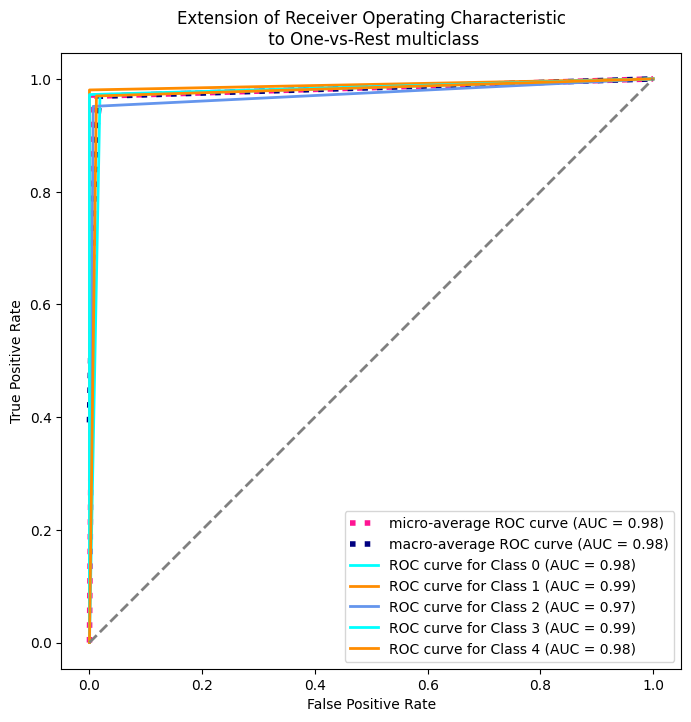

In [ ]:

plot_multiclass_roc_curve(all_labels, all_predictions)


## Testing model again on task 1


In [ ]:
val_accuracy, val_loss, all_predictions, all_labels  = validate(model_task2, device, val_loader_task1, task1_classes)

\Val set: Average loss: 18.3333, Accuracy: 52/206 (25%)



Alternatively, the model can be loaded using the best stored model trained on task 2

In [ ]:
model_task1_adapted = models.Net_log_softmax(classes=len(task1_classes)).to(device)

model_state_dict_task2 = torch.load("models/mnist_cnn_task2_MULTICLASS.pt")
model_task1_adapted.load_state_dict(model_state_dict_task2.copy()) 
test_accuracy, test_loss, all_predictions, all_labels  = validate(model_task1_adapted, device, val_loader_task1, task1_classes)

\Val set: Average loss: 18.5436, Accuracy: 53/206 (26%)



In [ ]:
np.unique(all_predictions), np.unique(all_labels)

(array([1, 3], dtype=int64), array([0, 1, 2, 3, 4], dtype=int64))

\Val set: Average loss: 18.3333, Accuracy: 52/206 (25%)



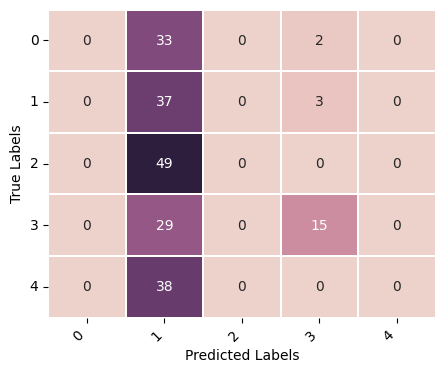

In [ ]:
test_accuracy, test_loss, all_predictions, all_labels = validate(model_task2, device,  val_loader_task1)
confusion_mat = confusion_matrix(all_labels, all_predictions )
conf_matrix = pd.DataFrame(confusion_mat)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
ax = sns.heatmap(conf_matrix,annot=True,  cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.1, cbar=False)

# Set labels and ticks  
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticklabels(range(confusion_mat.shape[0]), rotation=45, ha='right')
ax.set_yticklabels(range(confusion_mat.shape[0]), rotation=0)

# Display the plot
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=[str(c) for c in task1_classes]))


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.20      0.93      0.33        40
           2       0.00      0.00      0.00        49
           3       0.75      0.34      0.47        44
           4       0.00      0.00      0.00        38

    accuracy                           0.25       206
   macro avg       0.19      0.25      0.16       206
weighted avg       0.20      0.25      0.16       206



c:\ProgramData\anaconda3\envs\sebasmos\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\sebasmos\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\sebasmos\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


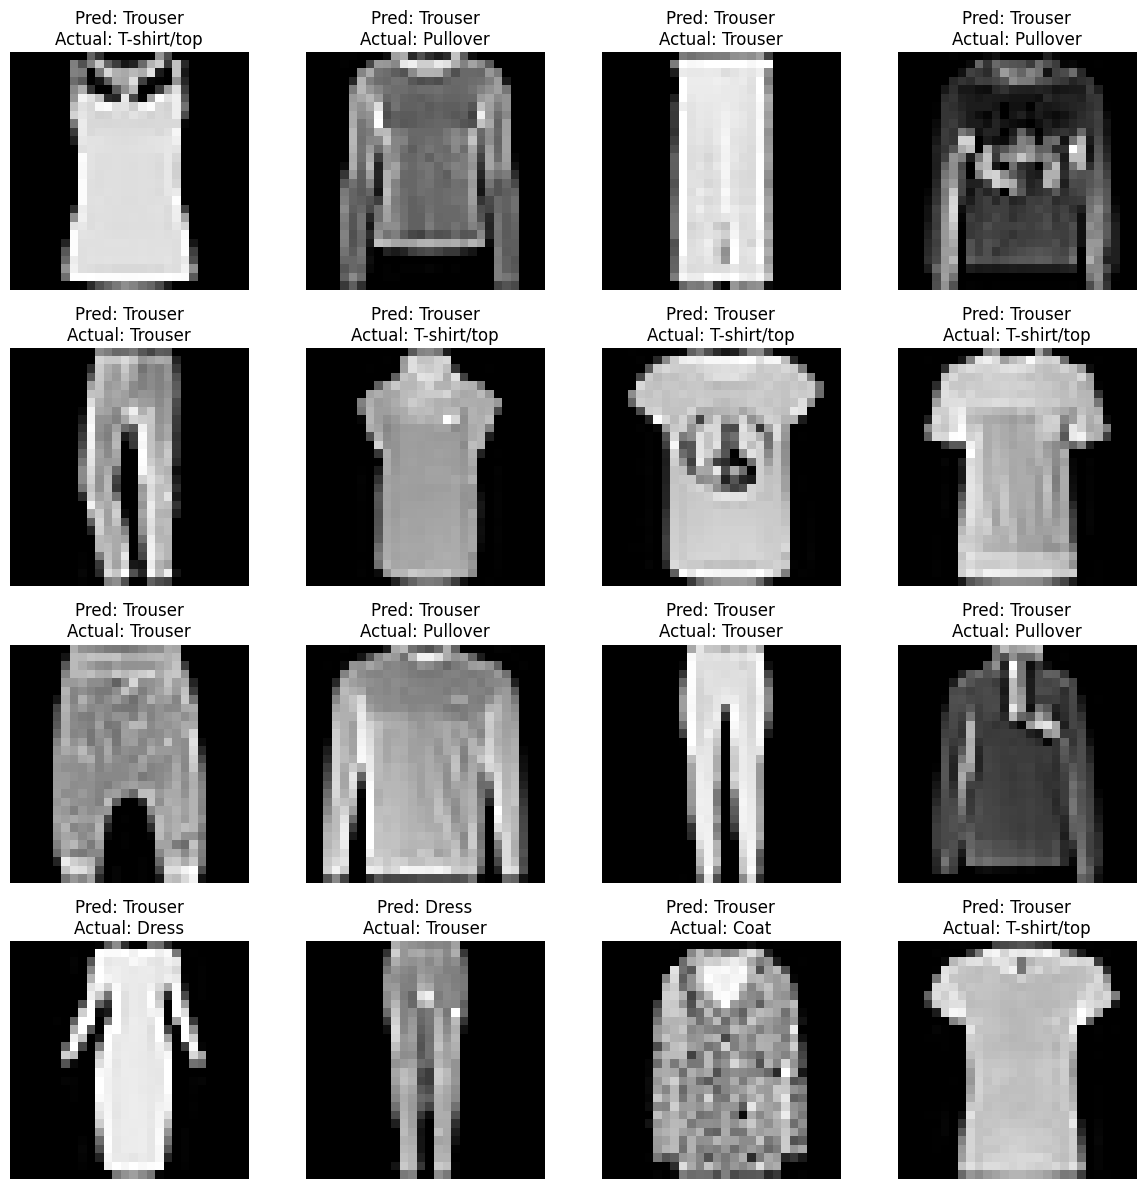

In [ ]:
visualize_predictions(model_task1_adapted, val_loader_task1, device, dataset_type=DATASET)

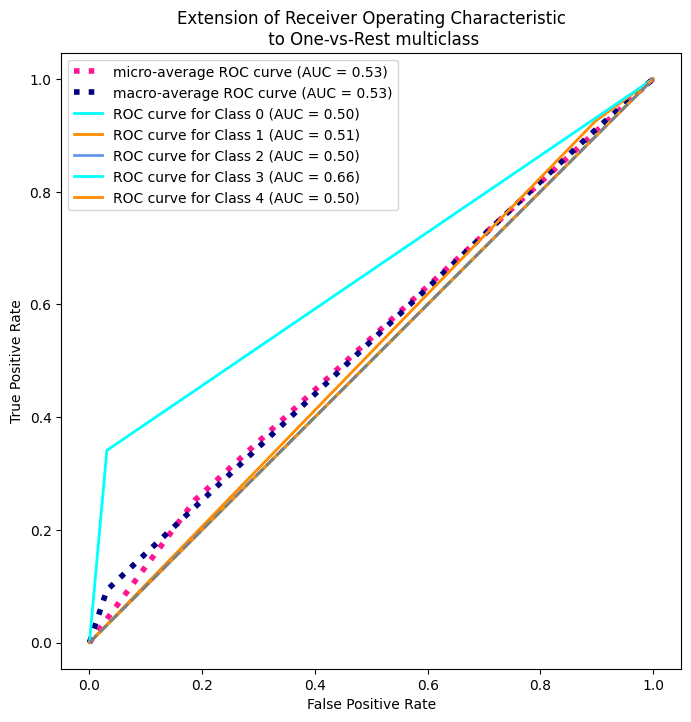

In [ ]:

plot_multiclass_roc_curve(all_labels, all_predictions)
